In [69]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import operator as op

## Messing around with likelihood of influx

Influx event defined as drawing $x^n \sim X^n$ AND $b^n \sim B^n$ such that $x^n = b^n$

In [204]:
# Define a response matrix to mess around with

def Qmatrix(q01, q10):
    """Single-bit resposne matrix. qij := p(i|j) for bitwise error"""
    return np.asarray([[1 - q10, q01],
                       [q10, 1 - q01]])


def Rmatrix(q01_arr, q10_arr):
    """Efficiently compute response matrix with normal ordering on indices."""
    out = Qmatrix(q01_arr[0], q10_arr[0])
    for j in range(1, len(q01_arr)):
        out = np.kron(out, Qmatrix(q01_arr[j], q10_arr[j]))
    return out


def binarr(m):
    """Produce an ordered column of all binary vectors length m.

    Example for m=3:
        array([[0, 0, 0],
               [0, 0, 1],
               [0, 1, 0],
               [0, 1, 1],
               [1, 0, 0],
               [1, 0, 1],
               [1, 1, 0],
               [1, 1, 1]])
    """
    d = np.arange(2 ** m)
    return (((d[:,None] & (1 << np.arange(m)))) > 0).astype(int)[:,::-1]


def idxsort_by_weight(m):
    """Sort [0, ..., 2**m] by bitstring weight.

    Returns the argsort that rearranges such an array according to the
    weight of each value's binary representation.
    """
    x = binarr(m)
    weights = np.sum(x, axis=1)
    return np.argsort(weights)


def int2bin_lendian(x, pad):
    s = str(bin(x)[2:])
    temp = "0" * (pad - len(s)) + s
    return temp


def ncr(n, r):
    """Efficient computation of n-choose-r"""
    r = min(r, n - r)
    numer = reduce(op.mul, range(n, n - r, -1), 1)
    denom = reduce(op.mul, range(1, r + 1), 1)
    return numer // denom


def u_imshow(u, n, title="", sort_by_weight=True):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # Rearrange labels on the space of U according to bitstring weight
    if sort_by_weight:
        idx = idxsort_by_weight(n)
        U_ordered = u[:,idx][idx,:]
    else:
        idx = np.arange(1 << n)
        U_ordered = u
    re = ax.imshow(U_ordered, cmap='seismic', vmin=-1, vmax=1)

    # fig.subplots_adjust(right=0.85)
    # cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    # fig.colorbar(im, cax=cbar_ax)
    ax.set_title("R", size=20)

    fig.suptitle(title)

    ticks = np.arange(1 << n)
    # ticklabels get shuffled according to weight
    ticklabs = [int2bin_lendian(i, n) for i in ticks[idx]]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabs, rotation=90, size=12)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabs, size=12)

    # Put boundaries between fixed-particle number regions
    if sort_by_weight:
        k = 0
        for i in range(n):
            k += ncr(n, i)
            ax.axhline(k - 0.5, ls=':', lw=1, c='k', alpha=1)
            ax.axvline(k - 0.5, ls=':', lw=1, c='k', alpha=1)

    return idx

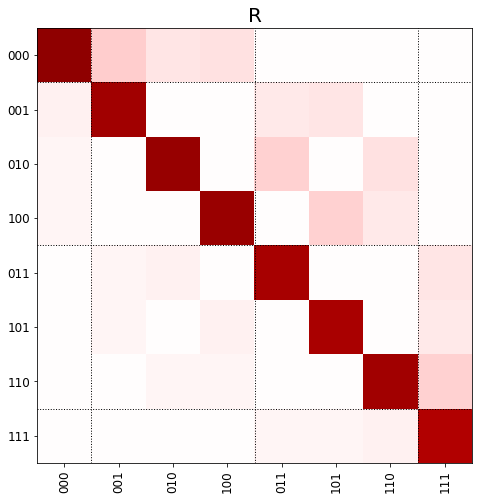

In [205]:
# Arrays of q(0|1) and q(1|0)
q01_arr = [0.06, .05, 0.1]
q10_arr = [0.02, .02, .03]
R = Rmatrix(q01_arr, q10_arr)
idx_sort = u_imshow(R, len(q01_arr), sort_by_weight=True)

### Truncated, inverted R

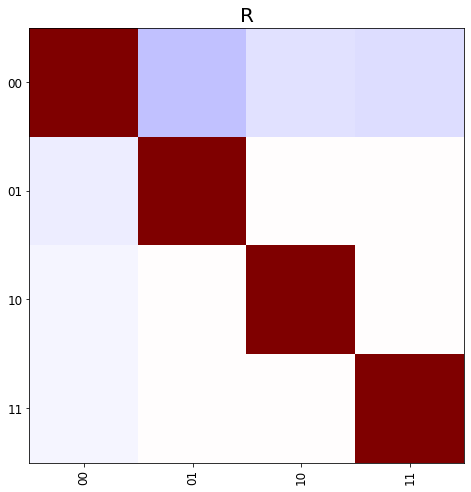

In [206]:
idx_sort = idxsort_by_weight(3)
R_sorted = R[:,idx_sort][idx_sort,:]
trunc_inv_R = np.linalg.inv(R_sorted)[:4,:4]
_ = u_imshow(trunc_inv_R, 2, sort_by_weight=False)

## Inverted truncated R

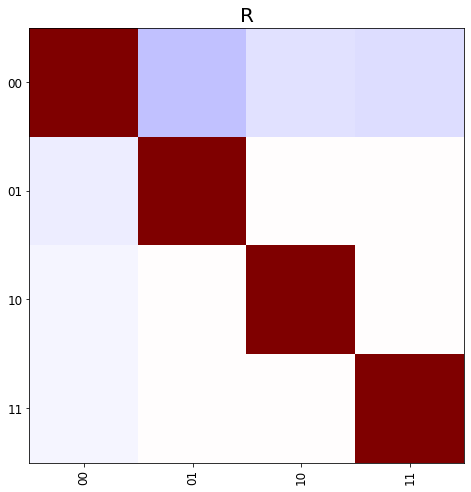

In [207]:
inv_trunc_R = np.linalg.inv(R_sorted[:4,:4])
idx_sort = u_imshow(inv_trunc_R, 2, sort_by_weight=False)

In [208]:
(inv_trunc_R - trunc_inv_R)[:,0]

array([-1.03188700e-05,  8.54894932e-05,  1.07620121e-04,  1.03533066e-04])

array([0, 1, 2, 4, 3, 5, 6, 7])

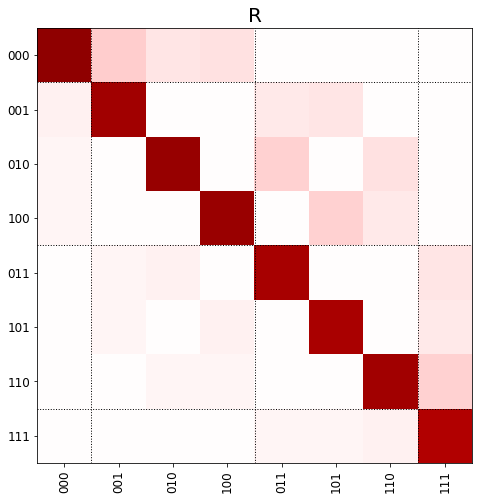

In [209]:
U, D, V_T = np.linalg.svd(R)
rr = np.zeros((8,8))
for j in range(8):
    rr += D[j] * np.kron(U[:,j].reshape(-1, 1), V_T[j,:].reshape(1, -1))
u_imshow_by_basis_weight(rr, len(q01_arr), sort_by_weight=True)

In [210]:
def schur_inverted_mat(mat, d):
    """Return the truncation (:d,:d) of inverted matrix"""
    A = mat[:d,:d]
    B = mat[:d, d:]
    C = mat[d:, :d]
    D = mat[d:, d:]
    return np.linalg.inv(A - B @ np.linalg.inv(D) @ C)
    

In [211]:
np.random.rand(6)

array([0.65133024, 0.80594787, 0.18341739, 0.27413887, 0.00277609,
       0.51664906])

In [225]:
# Arrays of q(0|1) and q(1|0)
n = 5
q01_arr = np.random.rand(n) * 0.3
q10_arr = np.random.rand(n) * 0.1
print(q01_arr)
print(q10_arr)
R = Rmatrix(q01_arr, q10_arr)

[0.13543218 0.12318945 0.14594277 0.28167075 0.13663096]
[0.04875143 0.04267177 0.0734457  0.02275514 0.06317948]


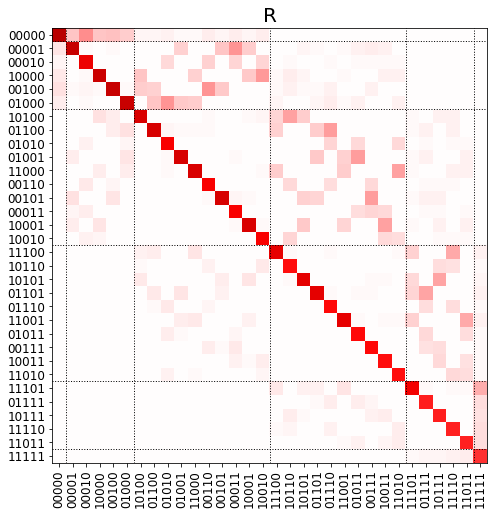

In [226]:
idx_sort = u_imshow_by_basis_weight(R, n, sort_by_weight=True)

In [227]:
# Only the first column of the invert/truncate process is relevant
k_trunc = 2 # weight to truncate to
R_sort = R[:,idx_sort][idx_sort,:]
inv_trunc_r = np.linalg.inv(R_sort[:n, :n])[:,0]
trunc_inv_r = np.linalg.inv(R_sort)[:n,0]

print(np.linalg.norm(inv_trunc_r - trunc_inv_r))

0.011295399917907694


In [224]:
schur_inverted_mat(R, n)[:,0]

array([ 1.30692255e+00, -2.51923427e-02, -1.60708973e-02,  3.09783891e-04,
       -1.27363970e-01])

array([ 1.30692255e+00, -2.51923427e-02, -1.60708973e-02,  3.09783891e-04,
       -1.27363970e-01])

In [87]:
w, v = np.linalg.eig(R)

In [91]:
v[idx_sort,1]

array([ 0.35355339, -0.35355339, -0.35355339, -0.35355339,  0.35355339,
        0.35355339,  0.35355339, -0.35355339])

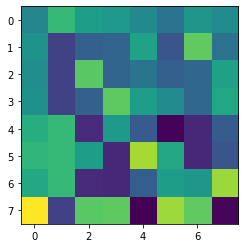

In [88]:
plt.imshow(v[idx_sort,:])

In [101]:
rr = np.zeros((8,8))
for ww, vv in zip(w, v.T):
    vv = vv.reshape(-1, 1)
    rr += ww * np.kron(vv, vv.T)

array([0, 1, 2, 4, 3, 5, 6, 7])

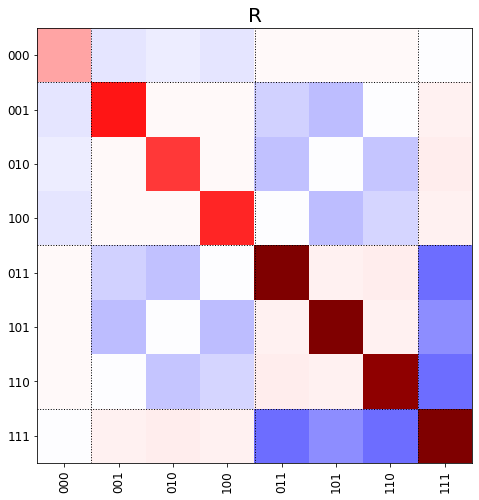

In [27]:
rank = 4
U_lr = U[:,:rank]
D_lr = D[:rank]
V_T_lr = V_T[:rank,:]
print(U_lr)
print(U_lr.shape)
print(D_lr.shape)
print(V_T_lr.shape)
R_lr = U[:rank,:] @ np.diag(D)[:rank] @ V_T[:rank,:]

[[-0.0591006   0.0911621  -0.1032885   0.15932149]
 [-0.26362013  0.40663145 -0.46072163  0.71065857]
 [-0.0911621  -0.0591006  -0.15932149 -0.1032885 ]
 [-0.40663145 -0.26362013 -0.71065857 -0.46072163]
 [-0.1032885   0.15932149  0.0591006  -0.0911621 ]
 [-0.46072163  0.71065857  0.26362013 -0.40663145]
 [-0.15932149 -0.1032885   0.0911621   0.0591006 ]
 [-0.71065857 -0.46072163  0.40663145  0.26362013]]
(8, 4)
(4,)
(4, 8)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 8)

In [7]:
def Bernoulli(q, size=1):
    return np.random.binomial(1, q, size=size)

def PBD(q_vals, size=1):
    """Sample from a Poisson Binomial Distribution parameterized on (q_1, ..., q_n).
    
    Returns:
        (size, n) array of binary values
    """
    out = np.zeros((size, len(q_vals)))
    for j, q in enumerate(q_vals):
        out[:,j] = Bernoulli(q, size=size)
    return out
    

In [6]:
Bernoulli(.4, size=10)

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1])

In [8]:
PBD([.2, .03, .06], size=10)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

### First: $P_{X_1 \dots X_n}$ is the uniform distrubtion except for P(0...0)

In [82]:
def zero_biased_uniform(n, p0, rows):
    """Sample from the distribution with P(0) = p0 and P(x != 0) = (1 - p0) / (2^n - 1)"""
#     out = np.random.randint(2, size=(rows, n))
    out = np.zeros((rows, n))
    for trial in range(rows):
        branch = np.random.rand(1)
        if branch > p0:
            new_row = np.random.randint(2, size=n)
            while sum(new_row) == 0:
                new_row = np.random.randint(2, size=n)
            out[trial, :] = new_row
        else:
            out[trial, :] = 0
            
    return out

ndraws = 10000
p_0 = .3

influx_fractions = []
outflux_fractions = []
zero_fractions = []
zero_prime_fractions = []

nmax = 20
system_sizes = np.arange(2, nmax)
# Set up a pre-determined set of bitflip probabilities so that this doesn't 
# affect the concentration of outflo
all_qvals = np.random.rand(nmax) * 0.10 # Uniform(0, 0.10)

for n in system_sizes:
#     zero_cts = int(p_0 * ndraws)
#     p0_vals = np.zeros((zero_cts, n))
#     other_vals = 
    Xvals = zero_biased_uniform(n, p_0, ndraws)
    
    # simulate bitflips
    qvals = all_qvals[:n]
    Bvals = PBD(qvals, size=ndraws)
    
    # Compute the original counts of 0...0
    locs_allzero = np.where(np.sum(Xvals, axis=1) == 0)[0]
    zero_counts = len(locs_allzero)
    zero_fractions.append(zero_counts )
    
    # Compute the counts of 0...0 after bitflips are applied  
    X_prime = (Xvals + Bvals) % 2 # simulates 'bitflips'
    zero_prime_counts = len(np.where(np.sum(X_prime, axis=1) == 0)[0])
    zero_prime_fractions.append(zero_prime_counts)
    
    # Compute the number of counts for which an all-zeros string was LOST due to outflux
    z_masked_B = Bvals[locs_allzero, :]
    outflux = len(np.where(np.sum(z_masked_B, axis=1) != 0)[0])
    outflux_fractions.append(outflux)
    
    # Compute the number of counts for which (b^n = x^n) AND (x^n != 0) which determines influx
    locs_nonzero = np.where(np.sum(Xvals, axis=1) != 0)[0]
    nz_masked_X = Xvals[locs_nonzero, :]
    nz_masked_B = Bvals[locs_nonzero, :]
    into_zero = (nz_masked_X + nz_masked_B) % 2 # all bitflips in the nonzero space

    influx = len(np.where(np.sum(into_zero, axis=1) == 0)[0])
    influx_fractions.append(influx)


In [83]:
print(zero_fractions)

[2957, 3057, 3035, 2984, 3008, 3015, 2985, 3002, 2919, 2934, 3022, 3028, 3016, 2959, 2988, 3002, 3072, 3009]


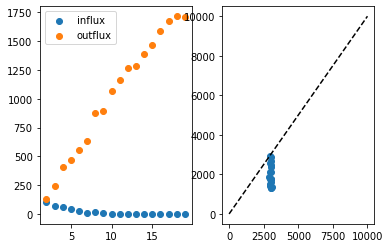

In [84]:
fig, axes = plt.subplots(1, 2)
axes[0].scatter(system_sizes, influx_fractions, label="influx")
axes[0].scatter(system_sizes, outflux_fractions, label="outflux")
axes[0].legend()

axes[1].scatter(zero_fractions, zero_prime_fractions)
axes[1].plot(range(ndraws), range(ndraws), ls='--', c='k')
# axes[1].scatter()

In [40]:
print(Xvals)
print(Bvals)
print(same_mask)

[[0 0 1 1 1]
 [1 0 1 1 1]
 [0 0 0 1 0]
 ...
 [1 1 1 1 0]
 [1 1 1 1 1]
 [1 0 0 1 1]]
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 1.]
 [1. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0.]
 ...
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 0. 0. 1. 1.]]


In [41]:
locs_same
print(influx)

126


In [33]:
Xvals[22]

array([0, 0, 1, 0, 0])

In [34]:
Bvals[22]

array([0., 0., 1., 0., 0.])

In [35]:
locs_same

(array([  22,   78,   85,   92,   94,  162,  242,  366,  385,  474,  547,
         553,  580,  661,  686,  697,  775,  784,  793,  961,  968, 1013,
        1024, 1070, 1095, 1110, 1196, 1208, 1224, 1256, 1304, 1310, 1338,
        1343, 1345, 1346, 1357, 1403, 1462, 1497, 1504, 1540, 1566, 1634,
        1675, 1721, 1798, 1815, 1828, 1857, 1866, 1868, 1926, 1927, 1947,
        2105, 2132, 2180, 2205, 2209, 2265, 2301, 2303, 2306, 2313, 2392,
        2477, 2541, 2577, 2579, 2944, 2983, 2990, 3012, 3022, 3036, 3041,
        3099, 3375, 3406, 3436, 3535, 3541, 3589, 3609, 3623, 3691, 3725,
        3779, 3832, 3875, 3957, 4003, 4007, 4014, 4023, 4052, 4061, 4213,
        4266, 4277, 4292, 4329, 4332, 4363, 4428, 4472, 4476, 4477, 4492,
        4532, 4549, 4580, 4664, 4684, 4686, 4693, 4697, 4700, 4703, 4708,
        4731, 4773, 4846, 4894, 4902]),)

In [ ]:
np.random